# Predictive Modelling with Regression

In [80]:
from datetime import datetime
import pandas as pd
from scripts.helper import reduce_mem_usage
from pycaret.regression import *
from pycaret.utils import check_metric
from pycaret.datasets import get_data
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)


## Import libraries

In [35]:
# Create datetime
today = datetime.today()
d1 = today.strftime("%d%m%Y")

## Import data

In [36]:
# Test dataset from pycaret library for classification modelling
# Comment it out if you're using the Capstone dataset!
#dataset_pycaret = get_data('credit')
dataset = pd.read_csv('data/feat_train_v2.csv')
dataset_test = pd.read_csv('data/feat_test_v2.csv')

In [37]:
#dataset_pycaret.info()

## Preparation for Modelling

In [38]:
numerical_cols = np.load("data/Numerical_Columns.npy")
categorical_cols = np.load("data/Categorical_Columns.npy")

In [39]:
type(numerical_cols)

numpy.ndarray

In [40]:
numerical_cols = numerical_cols.tolist()
categorical_cols = categorical_cols.tolist()

In [41]:
type(numerical_cols)

list

## Collect your customers !

In [42]:
test_id = dataset_test['fullVisitorId'].values

## Create Targets and Features

In [43]:
# Create target for classification model
reg_train = dataset[categorical_cols+numerical_cols]
reg_train['Target'] = dataset['totals.transactionRevenue']
reg_test = dataset_test[categorical_cols+numerical_cols]
reg_test['Target'] = dataset_test['totals.transactionRevenue']

In [85]:
totals_transactionRevenue_zero = reg_train[reg_train['Target'] == 0].sample(frac=1, random_state=10)
totals_transactionRevenue_nonzero = reg_train[reg_train['Target'] != 0]
reg_train = pd.concat([totals_transactionRevenue_zero, totals_transactionRevenue_nonzero], axis=0)

In [86]:
reg_train["Target"] = reg_train["Target"].apply(np.log1p)
reg_test["Target"] = reg_test["Target"].apply(np.log1p)

In [46]:
reg_train.shape

(1708337, 25)

## Regression Classification

Regression analysis is a set of statistical processes for estimating the relationships between a dependent variable (often called the 'outcome variable', or 'target') and one or more independent variables (often called 'features', 'predictors', or 'covariates'). The objective of regression in machine learning is to predict continuous values such as sales amount, quantity, temperature etc.

In order to demonstrate the predict_model() function on unseen data, a sample of xxxxx records has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these xxxxx records are not available at the time when the machine learning experiment was performed.

In [87]:
data_unseen = reg_test
#data.reset_index(inplace=True, drop=True)
#data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(reg_train.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (37028, 25)
Unseen Data For Predictions: (401589, 25)


## 1.0 Setting up environment in PyCaret

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [88]:
exp_clf101 = setup(data = reg_train, target = 'Target', session_id=123, numeric_features = categorical_cols+numerical_cols)

,Description,Value
0,session_id,123
1,Target,Target
2,Original Data,"(37028, 25)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(25919, 23)"


## 2.0 Comparing all models

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) along with training time.

In [49]:
# Run if you need to compare only !!!

#start_time = datetime.now()
# best_model = compare_models(['lightgbm'])
# end_time = datetime.now()
# print('Duration: {}'.format(end_time - start_time))

Two simple words of code (not even a line) have trained and evaluated over 20 models using cross validation. The score grid printed above highlights the highest performing metric for comparison purposes only. The grid by default is sorted using R2 (highest to lowest) which can be changed by passing sort parameter. For example compare_models(sort = 'RMSLE') will sort the grid by RMSLE (lower to higher since lower is better). If you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For example compare_models(fold = 5) will compare all models on 5 fold cross validation. Reducing the number of folds will improve the training time. By default, compare_models return the best performing model based on default sort order but can be used to return a list of top N models by using n_select parameter. </br>

Notice that how exclude parameter is used to block certain models (in this case RANSAC).

In [ ]:
print(best_model)

## 3.0 Create a Model

create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

There are 25 regressors available in the model library of PyCaret. To see list of all regressors either check the docstring or use models function to see the library.

In [ ]:
models()

### 3.1 AdaBoost Regressor

In [ ]:
#ada = create_model('ada')

In [ ]:
#print(ada)

### 3.2 Light Gradient Boosting Machine

In [89]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0406,0.0028,0.0534,0.2743,0.0136,0.0139
1,0.0406,0.0027,0.0523,0.2651,0.0133,0.0138
2,0.0429,0.0032,0.0564,0.2535,0.0143,0.0146
3,0.0417,0.0029,0.0542,0.2620,0.0138,0.0143
4,0.0402,0.0028,0.0531,0.2646,0.0136,0.0137
5,0.0415,0.0032,0.0562,0.2389,0.0144,0.0142
6,0.0412,0.0029,0.0535,0.2641,0.0136,0.0141
7,0.0410,0.0029,0.0539,0.2665,0.0137,0.0140
8,0.0415,0.0029,0.0542,0.2618,0.0138,0.0142
9,0.0415,0.0030,0.0545,0.2428,0.0138,0.0141


Notice that the Mean score of all models matches with the score printed in compare_models(). This is because the metrics printed in the compare_models() score grid are the average scores across all CV folds. Similar to compare_models(), if you want to change the fold parameter from the default value of 10 to a different value then you can use the fold parameter. For Example: create_model('dt', fold = 5) to create Decision Tree using 5 fold cross validation.

### ...

## 4. Tune a Model

When a model is created using the create_model function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold. To use the custom search grid, you can pass custom_grid parameter in the tune_model function (see 4.2 LightGBM tuning below).

In [ ]:
tuned_lightgbm=tune_model(lightgbm, optimize = 'RMSE')

### 4.1 AdaBoost Regressor

In [ ]:
#tuned_ada = tune_model(ada)

In [ ]:
#print(tuned_ada)

### 4.2 Light Gradient Boosting Machine

In [ ]:
# lgbm_params = {
#     'learning_rate': [0.005,0.01,0.015],   
#     'n_estimators': [40,100,200],          
#     'num_leaves': [6,8,12,15,16],          
#     'boosting_type' : ['gbdt'],
#     'objective' : ['regression'],          
#     'metric' : ['rmse'],                   
#     'colsample_bytree' : [0.6, 0.8, 1],    
#     'subsample' : [0.7,0.9, 1],            
#     'reg_alpha' : [0,1],                   
#     'reg_lambda' : [0,1],                  
#     'max_leaves': [128,256,512],           
#     'min_child_samples' : [1,20]           
#             }

In [ ]:
# tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)

In [ ]:
print(tuned_lightgbm)

By default, tune_model optimizes R2 but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'MAE') will search for the hyperparameters of a Decision Tree Regressor that results in the lowest MAE instead of highest R2. For the purposes of this example, we have used the default metric R2 for the sake of simplicity only.

Metrics alone are not the only criteria you should consider when finalizing the best model for production. Other factors to consider include training time, standard deviation of k-folds etc.

### ...

## 5. Plot a Model

Before model finalization, the plot_model() function can be used to analyze the performance across different aspects such as Residuals Plot, Prediction Error, Feature Importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

There are over 10 plots available, please see the plot_model() docstring for the list of available plots.

### 5.1 Residual Plot

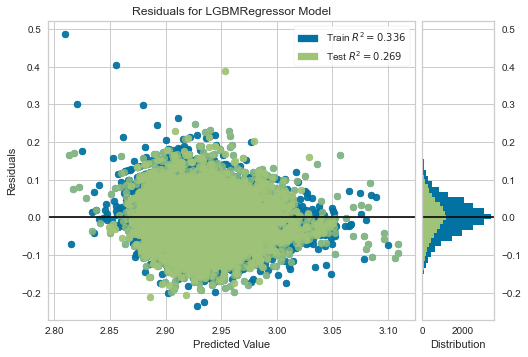

In [90]:
plot_model(lightgbm) # write here tuned_lightgbm

### 5.2 Prediction Error Plot

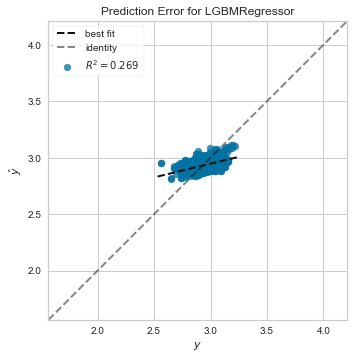

In [91]:
plot_model(lightgbm, plot = 'error') # write here tuned_lightgbm

### 5.3 Feature Importance Plot

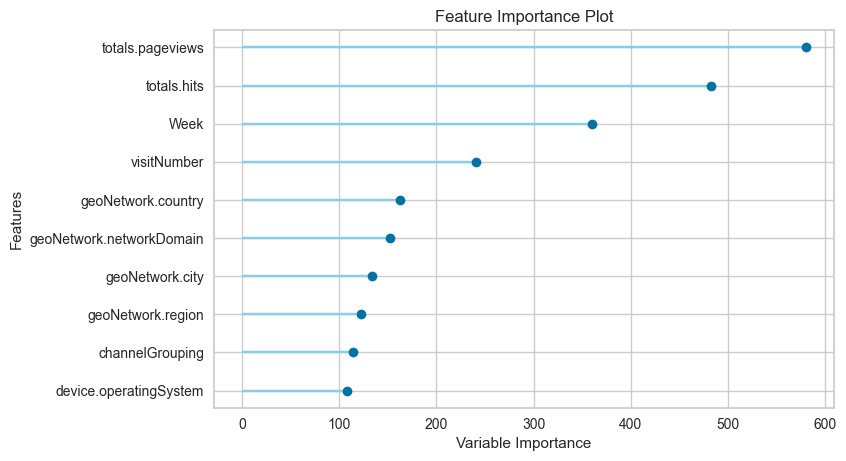

In [19]:
plot_model(lightgbm, plot='feature') # write here tuned_lightgbm

In [28]:
!pip install shap
interpret_model(lightgbm, plot='reason', observation=32)

     |████████████████████████████████| 356 kB 2.1 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp38-cp38-macosx_11_0_x86_64.whl size=415943 sha256=8125d697714368cd146729337fcc9e7992e31b2eab7ba828acbb6fc32abe1fc8
  Stored in directory: /Users/hsb/Library/Caches/pip/wheels/3d/c9/06/734ed80d6d61fad331974bf62017b4ea6b33488082b9f5e67e
Successfully built shap


Another way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [ ]:
#evaluate_model(lightgbm) # write here tuned_lightgbm

## 6 Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 1 above, you will see that xx% (xxxx samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross-validated results based on training set (70%) only. Now, using our final trained model stored in the tuned_lightgbm variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [ ]:
lightgbm = ensemble_model(lightgbm, method = 'Bagging')

In [51]:
predict_model(lightgbm); # write here tuned_lightgbm

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2684,2.3289,1.5261,0.3191,0.3093,0.6848


The R2 on the test/hold-out set is 0.xxxx compared to 0.xxxx achieved on tuned_lightgbm CV results (in section 9.2 above). This is not a significant difference. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 10% that we had separated in the beginning and never exposed to PyCaret).

(TIP : It's always good to look at the standard deviation of CV results when using create_model.)

## 7 Finalize Model for Deplyoment

Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [52]:
final_lightgbm = finalize_model(lightgbm) # write here tuned_lightgbm

In [ ]:
print(final_lightgbm)

In [ ]:
# have it twice for comparison
print(final_lightgbm)

Caution: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling. In order to demonstrate this point only, we will use final_lightgbm under predict_model() to compare the information grid with the one above in section 11.

In [53]:
predict_model(final_lightgbm); 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2630,2.2345,1.4948,0.3467,0.3052,0.6719


Notice how the R2 in the final_lightgbm has increased to 0.xxxx from 0.xxxx, even though the model is same. This is because the final_lightgbm variable is trained on the complete dataset including the test/hold-out set.

## 8. Predict on unseen data

The predict_model() function is also used to predict on the unseen dataset. The only difference from section 11 above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 10% (xxx samples) of the original dataset which was never exposed to PyCaret.

In [54]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)

The Label and Score columns are added onto the data_unseen set. Label is the prediction and score is the probability of the prediction. Notice that predicted results are concatenated to the original dataset while all the transformations are automatically performed in the background. You can also check the metrics on this since you have actual target column default available. To do that we will use pycaret.utils module. See example below:

In [24]:
check_metric(unseen_predictions["Target"], unseen_predictions.Label, 'RMSE')

2.6237

In [55]:
unseen_predictions['date']= dataset_test['date']

In [56]:
unseen_predictions.to_csv('model/dataset_pred.csv')

## 9. Saving the model

We have now finished the experiment by finalizing the tuned_rf model which is now stored in final_rf variable. We have also used the model stored in final_rf to predict data_unseen. This brings us to the end of our experiment, but one question is still to be asked: What happens when you have more new data to predict? Do you have to go through the entire experiment again? The answer is no, PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.

In [ ]:
save_model(final_lightgbm,'model/Reg_lgbm_Model_{}'.format(d1))

## 10. Loading the saved model

To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.

In [ ]:
saved_final_lightgbm = load_model('model/Reg_lgbm_Model_{}'.format(d1))

# 11. Final part -  Creating submission file

### Saving the Labels for regression labels

In [57]:
sub_reg = unseen_predictions['Label']
sub_reg.head()

0    0.001931
1    0.011960
2    0.002074
3    0.011663
4    0.003952
Name: Label, dtype: float64

In [58]:
sub_reg.to_csv("model/sub_reg.csv",index=False)

### Calling back reg and class models

In [59]:
sub_reg = pd.read_csv("model/sub_reg.csv")
sub_class = pd.read_csv("model/sub_class.csv")

In [60]:
pred_test =  sub_reg.Label 

### Getting FullvisitorID for aggregating with respect to it

In [61]:
test_id = dataset_test["fullVisitorId"].values
pred_target = pd.DataFrame({"fullVisitorId":test_id})

### This is the part to get Predict Target with fullVisitorId

In [62]:
# Removing negative values
pred_test[pred_test<0] = 0
pred_target["PredictedLogRevenue"] = np.expm1(pred_test)
pred_target = pred_target.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()

### Submission file ready below !

In [63]:
pred_target.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_target["PredictedLogRevenue"] = np.log1p(pred_target["PredictedLogRevenue"])
pred_target.to_csv("model/submission.csv", index=False)

In [64]:
# Final submission file
pred_target.head()

,fullVisitorId,PredictedLogRevenue
0,1995526696366,0.000417
1,16367580689231,0.007971
2,18966949534117,0.000000
3,24844201502183,0.007942
4,24845665201193,0.001628


# 12. RMSE TEST by us

### This is the part to get Actual Target with fullVisitorId to compare the previously Predict Target

In [65]:
act_target = pd.DataFrame({"fullVisitorId":test_id})
act_target.head()

,fullVisitorId
0,7460955084541987166
1,460252456180441002
2,3461808543879602873
3,975129477712150630
4,8381672768065729990


In [66]:
act_target["Target_actual"] = np.expm1(unseen_predictions['Target'])
act_target = act_target.groupby("fullVisitorId")["Target_actual"].sum().reset_index()

In [92]:
act_target.columns = ["fullVisitorId", "Target_actual"]
act_target["Target_actual"] = np.log1p(1+act_target["Target_actual"])
act_target.head()

,fullVisitorId,Target_actual
0,1995526696366,0.526589
1,16367580689231,0.526589
2,18966949534117,0.526589
3,24844201502183,0.526589
4,24845665201193,0.526589


In [93]:
RMSE = np.sqrt((sum( (act_target['Target_actual'].values - pred_target['PredictedLogRevenue'].values) **2)) / len(act_target))

In [94]:
print(f'Your RMSE Score is: {RMSE}')

Your RMSE Score is: 1.0303756746725707


In [30]:
dataset.head()

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,device.browser,device.isMobile,device.operatingSystem,geoNetwork.city,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Week,Year,Month,hits_mean_city,pageviews_mean_city
0,0,4,2017-10-17,3162355547410993243,1508198450,1.0,64,0.0,22,1096,...,0,3760,5,0,117,42.0,2017,10.0,4.0,3.0
1,1,6,2017-10-16,8934116514970143966,1508176307,6.0,55,0.0,3,256,...,0,8,6,340,339,42.0,2017,10.0,6.0,5.0
2,2,2,2017-10-17,7992466427990357681,1508201613,1.0,55,1.0,1,1096,...,1,8,0,0,0,42.0,2017,10.0,4.0,3.0
3,3,4,2017-10-16,9075655783635761930,1508169851,1.0,55,0.0,22,1096,...,0,8,5,0,117,42.0,2017,10.0,4.0,3.0
4,4,4,2017-10-16,6960673291025684308,1508190552,1.0,55,0.0,22,1096,...,0,8,5,0,117,42.0,2017,10.0,4.0,3.0


## Error Analysis


In [75]:
error_df = pd.DataFrame(data = {'visitStartTime':dataset['date'],'fullVisitorId':dataset['fullVisitorId'], 
                                'True_log_revenue' : act_target['Target_actual'], 
                                'Predicted_log_revenue':pred_target['PredictedLogRevenue']  })

error_df['Difference'] = error_df['True_log_revenue'] - error_df['Predicted_log_revenue']
error_df['True_is_non_zero'] = error_df['True_log_revenue'] > 0
#temp_df.columns = ['fullVisitorId', 'predictedLogRevenue']
#sub_df['predictedLogRevenue'] = np.log1p(sub_df['predictedLogRevenue'])
#sub_df.to_csv(file_name, index = False)
error_df.sort_values('visitStartTime').head(10)

,visitStartTime,fullVisitorId,True_log_revenue,Predicted_log_revenue,Difference,True_is_non_zero
996806,2016-08-01,2759203598427661079,NaN,NaN,NaN,False
996877,2016-08-01,4597308409158508498,NaN,NaN,NaN,False
996876,2016-08-01,7180771470273032233,NaN,NaN,NaN,False
996875,2016-08-01,3652538119409785696,NaN,NaN,NaN,False
996874,2016-08-01,3259411844793303374,NaN,NaN,NaN,False
996873,2016-08-01,0233470704323760007,NaN,NaN,NaN,False
996872,2016-08-01,0948227249440399192,NaN,NaN,NaN,False
996870,2016-08-01,4519579316106061221,NaN,NaN,NaN,False
996878,2016-08-01,1768021879618184521,NaN,NaN,NaN,False
996868,2016-08-01,476419139818968912,NaN,NaN,NaN,False


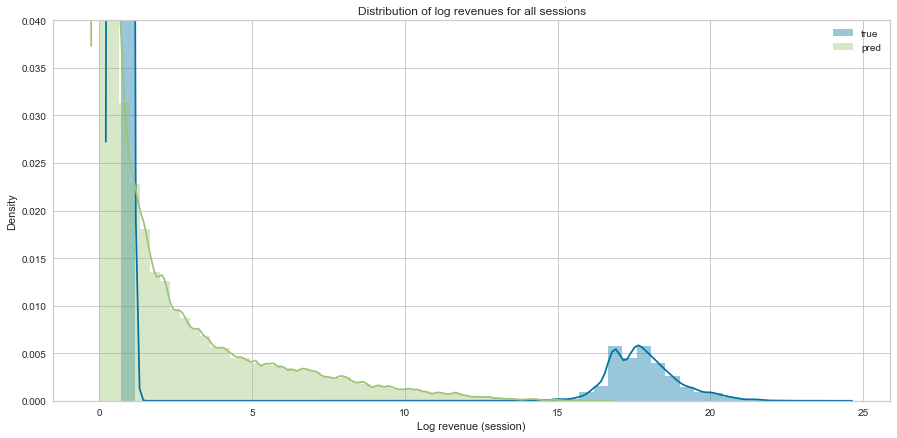

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,7))

sns.distplot(error_df['True_log_revenue'], ax = ax, label = 'true')
sns.distplot(error_df['Predicted_log_revenue'], ax = ax, label = 'pred')
ax.legend()
ax.set_ylim(0,.04)
ax.set_xlabel('Log revenue (session)')
ax.set_title('Distribution of log revenues for all sessions')

plt.show()